# Load data and library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import sys
import ast

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate, KFold, train_test_split

from lightgbm import LGBMClassifier
import lightgbm as lgb

In [2]:
# helper function to get the feature preprocessing pipeline
def get_feature_pipeline(numerical, nominal, ordinal, algorithm):
    preprocess_numerical = FunctionTransformer(lambda x: x[numerical], validate = False)
    preprocess_nominal = FunctionTransformer(lambda x: x[nominal], validate = False)
    preprocess_ordinal = FunctionTransformer(lambda x: x[ordinal], validate = False)
    if algorithm == 'Logistic Regression':
        pl_numerical = Pipeline([('selector_numerical', preprocess_numerical),
                                 ('imputer', SimpleImputer(strategy = 'median')),
                                 ('scaler', MinMaxScaler())])                    
        pl_nominal = Pipeline([('selector_nominal', preprocess_nominal),
                               ('imputer', SimpleImputer(strategy = 'most_frequent')),
                               ('encoder', OneHotEncoder())])
        pl_ordinal = Pipeline([('selector_ordinal', preprocess_ordinal),
                               ('imputer', SimpleImputer(strategy = 'most_frequent')),
                               ('encoder', OrdinalEncoder())])
        feature_pipeline = FeatureUnion([('pipeline_numerical', pl_numerical),
                                         ('pipeline_nominal', pl_nominal),
                                         ('pipeline_ordinal', pl_ordinal)])
        return feature_pipeline
    
    elif algorithm == 'GBM':
        pl_numerical = Pipeline([('selector_numerical', preprocess_numerical)])
        pl_nominal = Pipeline([('selector_nominal', preprocess_nominal),
                               ('encoder', OneHotEncoder())])
        pl_ordinal = Pipeline([('selector_ordinal', preprocess_ordinal),
                               ('encoder', OrdinalEncoder())])
        feature_pipeline = FeatureUnion([('pipeline_numerical', pl_numerical),
                                         ('pipeline_nominal', pl_nominal),
                                         ('pipeline_ordinal', pl_ordinal)])
        return feature_pipeline
    else:
        print('algorithm argument is wrong. Try "Logistic Regression" or "GBM"!')
        return None

# helper function to evaluate the model performance
def model_evaluation(model, train, test, name):
    """ Parameter:
            model - trained model
            train - list of train feature and train target ---> [X_train, y_train]
            test - test feature ---> X_test
            name - trained model's name
    """
    X_train = train[0]; y_train = train[1]
    X_test = test
    
    # predict the model
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # training model performance
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    roc_auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train)
    roc_auc_cv = cross_validate(estimator = model, X = X_train, y = y_train, cv = 5, scoring = 'roc_auc', return_train_score = True)
    dict_model_performance = {'Accuracy train':accuracy_train.round(3),
                              'ROC AUC 5-CV train':'{} ± {}'.format(roc_auc_cv['train_score'].mean().round(3), roc_auc_cv['train_score'].std().round(3)),
                              'ROC AUC 5-CV validate':'{} ± {}'.format(roc_auc_cv['test_score'].mean().round(3), roc_auc_cv['test_score'].std().round(3)), 
                              'ROC AUC train':roc_auc_train.round(3)}
    print('\n')
    print ('======== model evaluation metrics "{}" ========'.format(name))
    print('confusion matrix and classification report "app_train": \n{0}\n{1}'.format(metrics.confusion_matrix(y_train, y_pred_train), 
                                                                                      metrics.classification_report(y_train, y_pred_train, target_names = ['repaid', 'not repaid'])))
    df = pd.DataFrame([dict_model_performance])
    df.rename(index = {0:name}, inplace = True)
    return df, y_pred_proba_test

# get the feature importance from LGMB
def feature_importance(model,plot = True, max_num_features = 15, figsize = (6, 4)):
    numerical = list(model[0].transformer_list[0][1].steps[0][1].transform(app_train).columns)
    ordinal = list(model[0].transformer_list[2][1].steps[1][1].feature_names_in_)
    nominal = list(model[0].transformer_list[1][1].steps[1][1].get_feature_names_out())
    all_columns = numerical + ordinal + nominal
    df = pd.DataFrame({'Feature':all_columns, 'Number of Split':model[1].feature_importances_}).sort_values('Number of Split', ascending = True).set_index('Feature')
    if plot == True:
        fig, ax = plt.subplots(figsize = figsize)
        df.tail(max_num_features).plot(kind = 'barh', ax = ax)
        ax.set_title('Feature Importance LGBM')
        plt.show()
    return df

In [3]:
%%time
# load the final train and test dataset
app_train = pd.read_csv('final train and test dataset/app_train_final.csv')
app_test = pd.read_csv('final train and test dataset/app_test_final.csv')

# load the column names
column_names = pd.read_csv('final train and test dataset/column_names.csv')

num_columns = ast.literal_eval(column_names[column_names['variable'] == 'num_columns']['list'].tolist()[0])
cat_columns = ast.literal_eval(column_names[column_names['variable'] == 'cat_columns']['list'].tolist()[0])
nom_columns = ast.literal_eval(column_names[column_names['variable'] == 'nom_columns']['list'].tolist()[0])
ord_columns = ast.literal_eval(column_names[column_names['variable'] == 'ord_columns']['list'].tolist()[0])
poly_columns = ast.literal_eval(column_names[column_names['variable'] == 'poly_columns']['list'].tolist()[0])
creation_columns = ast.literal_eval(column_names[column_names['variable'] == 'creation_columns']['list'].tolist()[0])
bureau_app_columns = ast.literal_eval(column_names[column_names['variable'] == 'bureau_app_columns']['list'].tolist()[0])
previous_app_columns = ast.literal_eval(column_names[column_names['variable'] == 'previous_app_columns']['list'].tolist()[0])

Wall time: 28.8 s


In [4]:
print('app_train shape:', app_train.shape)
print('app_test shape:', app_test.shape)

app_train shape: (307511, 709)
app_test shape: (48744, 708)


In [5]:
app_train['CODE_GENDER'] = pd.Categorical(app_train['CODE_GENDER'], ordered = True, categories = ['F', 'M'])
app_test['CODE_GENDER'] = pd.Categorical(app_test['CODE_GENDER'], ordered = True, categories = ['F', 'M'])

app_train['FLAG_OWN_CAR'] = pd.Categorical(app_train['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_CAR'] = pd.Categorical(app_test['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])

app_train['FLAG_OWN_REALTY'] = pd.Categorical(app_train['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_REALTY'] = pd.Categorical(app_test['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])

app_train['YEARS_BIRTH_SEGMENT'] = pd.Categorical(app_train['YEARS_BIRTH_SEGMENT'], ordered = True)
app_test['YEARS_BIRTH_SEGMENT'] = pd.Categorical(app_test['YEARS_BIRTH_SEGMENT'], ordered = True)

# Hyperparameter tuning

The best model we see from previous notebook `Part 2 - Modeling` is LGBM model using features from `num_columns`, `nom_columns`, `ord_columns`, `creation_columns`, `bureau_app_columns`, and `previous_app_columns`. Therefore we will try to tune LGBM's hyperparameter model using those features in order to get the better performance.

In [6]:
%%time
# preprocessing the features

# set the feature pipeline
LGBM_features_total = get_feature_pipeline(numerical = num_columns + creation_columns + bureau_app_columns + previous_app_columns, 
                                           nominal = nom_columns, 
                                           ordinal = ord_columns, 
                                           algorithm = 'GBM')
# train data and test data
X_train = LGBM_features_total.fit_transform(app_train)
y_train = app_train[['TARGET']]
X_test = LGBM_features_total.transform(app_test)
display(X_train)
display(X_test)

# extract the features from preprocessing pipeline
num_after = LGBM_features_total.transformer_list[0][1].steps[0][1].transform(app_train).columns.tolist()
nom_after = LGBM_features_total.transformer_list[1][1].steps[1][1].get_feature_names_out().tolist()
ord_after = LGBM_features_total.transformer_list[2][1].steps[1][1].feature_names_in_.tolist()
all_columns_after = num_after + nom_after + ord_after
print('Total features after preprocessing in Pipeline:', len(all_columns_after))

<307511x793 sparse matrix of type '<class 'numpy.float64'>'
	with 132771518 stored elements in Compressed Sparse Row format>

<48744x793 sparse matrix of type '<class 'numpy.float64'>'
	with 20640285 stored elements in Compressed Sparse Row format>

Total features after preprocessing in Pipeline: 793
Wall time: 39.4 s


In [7]:
import re
# train set df
train_features = pd.DataFrame(X_train.toarray(), columns = all_columns_after)
train_features = train_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_labels = y_train.copy()

# test set df
test_features = pd.DataFrame(X_test.toarray(), columns = all_columns_after)
test_features = test_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(train_features.shape, train_labels.shape)
print(test_features.shape)

(307511, 793) (307511, 1)
(48744, 793)


In [8]:
params = {'verbose': -1}

# training set
train_set = lgb.Dataset(train_features, label = train_labels, params = params)
test_set = lgb.Dataset(test_features, params = params)

## Bayesian optimization

### Objective function

In [9]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'max_depth']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
        
    # Remove verbose in training process
    hyperparameters['verbose'] = -1
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 1000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 420, verbose_eval = False)

    run_time = timer() - start
    
    # Remove 'verbose' in hyperparameters dict
    hyperparameters.pop('verbose')
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()
    print('ITERATION: {0} ---> time: {1}'.format(ITERATION, run_time))

    return loss

### Domain search

In [10]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'subsample': hp.uniform('subsample', 0.4, 1.0),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.05), np.log(0.5)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True])
}

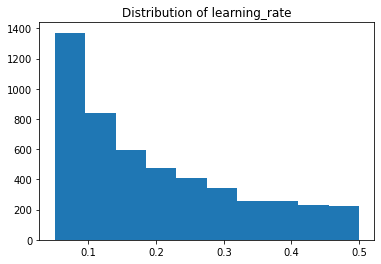

In [11]:
def check_dist(space, param):
    value = []
    for i in range(5000):
        value.append(sample(space)[param])
    plt.hist(value)
    plt.title('Distribution of {}'.format(param))
    plt.show()
check_dist(space, 'learning_rate')

In [12]:
# sample
hyperparameters = sample(space)
display(hyperparameters)

if 'n_estimators' in hyperparameters:
    del hyperparameters['n_estimators']

for parameter_name in ['num_leaves', 'max_depth']:
    hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
display(hyperparameters)

{'boosting_type': 'dart',
 'colsample_bytree': 0.651324653372059,
 'is_unbalance': True,
 'learning_rate': 0.1963788472326696,
 'max_depth': 6.0,
 'num_leaves': 149.0,
 'reg_alpha': 0.5393254723303981,
 'reg_lambda': 0.3568693024594267,
 'subsample': 0.4998174450741046}

{'boosting_type': 'dart',
 'colsample_bytree': 0.651324653372059,
 'is_unbalance': True,
 'learning_rate': 0.1963788472326696,
 'max_depth': 6,
 'num_leaves': 149,
 'reg_alpha': 0.5393254723303981,
 'reg_lambda': 0.3568693024594267,
 'subsample': 0.4998174450741046}

### Process

In [13]:
from hyperopt import fmin, Trials, tpe

In [14]:
# Create a file and open a connection
OUT_FILE = 'LGBM_total - Bayesian Optimization (tuned_LGBM_2).csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [15]:
# Record results
trials = Trials()

In [16]:
MAX_EVALS = 100
N_FOLDS = 5

global ITERATION

ITERATION = 0

best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = MAX_EVALS)

ITERATION: 1 ---> time: 175.06616069999998                                                                             
ITERATION: 2 ---> time: 274.17143200000004                                                                             
ITERATION: 3 ---> time: 1506.0826756000001                                                                             
ITERATION: 4 ---> time: 1802.7004607000001                                                                             
ITERATION: 5 ---> time: 181.48142740000003                                                                             
ITERATION: 6 ---> time: 156.40519749999976                                                                             
ITERATION: 7 ---> time: 1535.6129174999996                                                                             
ITERATION: 8 ---> time: 310.68315320000056                                                                             
ITERATION: 9 ---> time: 136.394501200000

ITERATION: 69 ---> time: 1825.5490734999985                                                                            
ITERATION: 70 ---> time: 1802.0383072999975                                                                            
ITERATION: 71 ---> time: 1600.726300800001                                                                             
ITERATION: 72 ---> time: 1523.8783470999988                                                                            
ITERATION: 73 ---> time: 957.4523647000024                                                                             
ITERATION: 74 ---> time: 1219.7576905999958                                                                            
ITERATION: 75 ---> time: 1411.8928038999875                                                                            
ITERATION: 76 ---> time: 1184.7190255000023                                                                            
ITERATION: 77 ---> time: 1099.1908345999

NameError: name 'json' is not defined

In [48]:
import pickle
# save the model to disk
filename = 'LGBM_total - Trials Bayesian Optimization (tuned_LGBM_2).sav'
pickle.dump(trials, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

### Fit the best params and evaluate

In [106]:
bayesian_results = pd.read_csv('LGBM_total - Bayesian Optimization (tuned_LGBM_2).csv').sort_values(by = 'loss')
bayesian_results

,loss,hyperparameters,iteration,runtime,score
71,0.216684,"{'boosting_type': 'dart', 'colsample_bytree': ...",72,1523.878347,0.783316
97,0.216931,"{'boosting_type': 'dart', 'colsample_bytree': ...",98,1236.843890,0.783069
74,0.217050,"{'boosting_type': 'dart', 'colsample_bytree': ...",75,1411.892804,0.782950
25,0.217092,"{'boosting_type': 'dart', 'colsample_bytree': ...",26,1326.979612,0.782908
24,0.217158,"{'boosting_type': 'dart', 'colsample_bytree': ...",25,1416.112261,0.782842
...,...,...,...,...,...
8,0.232520,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",9,136.394501,0.767480
17,0.233585,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",18,248.833689,0.766415
34,0.234917,"{'boosting_type': 'dart', 'colsample_bytree': ...",35,936.554213,0.765083
15,0.238108,"{'boosting_type': 'dart', 'colsample_bytree': ...",16,1377.790747,0.761892


In [116]:
# best hyperparameters
hyperparameters = ast.literal_eval(bayesian_results.head(1).hyperparameters.tolist()[0])
hyperparameters

{'boosting_type': 'dart',
 'colsample_bytree': 0.5590968433055882,
 'is_unbalance': True,
 'learning_rate': 0.06924087417014092,
 'max_depth': 6,
 'num_leaves': 48,
 'reg_alpha': 0.9624493183295199,
 'reg_lambda': 0.373874171328887,
 'subsample': 0.6090034292579527,
 'n_estimators': 1000}

In [119]:
%%time
# create model for LGBM: tuned_LGBM_2
LGBM_features_total = get_feature_pipeline(numerical = num_columns + creation_columns + bureau_app_columns + previous_app_columns, 
                                           nominal = nom_columns, 
                                           ordinal = ord_columns, 
                                           algorithm = 'GBM')

tuned_LGBM_2 = LGBMClassifier(**hyperparameters, random_state = 42, 
                              class_weight = 'balanced', objective = 'binary', n_jobs = -1)

tuned_LGBM_2 = Pipeline([('preprocessing_features', LGBM_features_total),
                         ('LGBM', tuned_LGBM_2)], verbose = True)

tuned_LGBM_2.fit(app_train.drop('TARGET', axis = 1),
                 app_train[['TARGET']])
print('done...')

[Pipeline]  (step 1 of 2) Processing preprocessing_features, total= 1.5min
[Pipeline] .............. (step 2 of 2) Processing LGBM, total= 6.6min
done...
Wall time: 8min 16s


In [125]:
import pickle
# save the model to disk
filename = 'LGBM_total - Best Params (tuned_LGBM_2).sav'
pickle.dump(tuned_LGBM_2[1], open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.5590968433055882, is_unbalance=True,
               learning_rate=0.06924087417014092, max_depth=6,
               n_estimators=1000, num_leaves=48, objective='binary',
               random_state=42, reg_alpha=0.9624493183295199,
               reg_lambda=0.373874171328887, subsample=0.6090034292579527)

In [127]:
%%time
# evaluate tuned_LGBM_2
df_tuned_LGBM_2, y_pred_proba_test = model_evaluation(model = tuned_LGBM_2[1], 
                                                      train = [X_train, y_train], 
                                                      test = X_test, 
                                                      name = 'tuned_LGBM_2')
display(df_tuned_LGBM_2)



======== model evaluation metrics "tuned_LGBM_2" ========
confusion matrix and classification report "app_train": 
[[ 44739 237947]
 [     0  24825]]
              precision    recall  f1-score   support

      repaid       1.00      0.16      0.27    282686
  not repaid       0.09      1.00      0.17     24825

    accuracy                           0.23    307511
   macro avg       0.55      0.58      0.22    307511
weighted avg       0.93      0.23      0.27    307511



,Accuracy train,ROC AUC 5-CV train,ROC AUC 5-CV validate,ROC AUC train
tuned_LGBM_2,0.226,0.898 ± 0.001,0.765 ± 0.002,0.884


Wall time: 30min 12s


In [128]:
# create submission dataframe and save the submission to a csv file
df_submit = app_test[['SK_ID_CURR']].copy()
df_submit['TARGET'] = y_pred_proba_test
df_submit.to_csv('submission/tuned_LGBM_2.csv', index = False)
df_submit.head()

,SK_ID_CURR,TARGET
0,100001,0.486146
1,100005,0.938105
2,100013,0.348974
3,100028,0.722819
4,100038,0.939451


In [130]:
df_tuned_LGBM_2['ROC AUC test'] = round(0.75505, 3)
df_tuned_LGBM_2

,Accuracy train,ROC AUC 5-CV train,ROC AUC 5-CV validate,ROC AUC train,ROC AUC test
tuned_LGBM_2,0.226,0.898 ± 0.001,0.765 ± 0.002,0.884,0.755


- The `ROC AUC test` score is obtained after submit the submission file to [Kaggle](https://www.kaggle.com/competitions/home-credit-default-risk/overview) that is `0.75505`.
- The model overfit the training set.